# This is the notebook for K-Nearest Neighbors 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from skimage import feature
from skimage import transform
import warnings
warnings.filterwarnings("ignore")

In [2]:
from helper import *

Load training data:

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)] 

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

N_IMAGES_TRAIN = len(files)

In [4]:
# Extract patches from input images
patch_size = 8 

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(N_IMAGES_TRAIN)]
# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [5]:
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(gt_patches[i], foreground_threshold) for i in range(len(gt_patches))])

In [6]:
from imblearn.under_sampling import RandomUnderSampler

In [7]:
rus = RandomUnderSampler()

In [8]:
X_resampled, Y_resampled = rus.fit_resample(X, Y)

## 1. K-NN Classifier for silly features

In [9]:
from sklearn import neighbors
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [10]:
n_neigh = np.arange(1, 40)
cvs = np.zeros(39)
for inn, nn in enumerate(n_neigh):
    knn_model = neighbors.KNeighborsClassifier(n_neighbors=nn, n_jobs=2, p=1)
    cv = ShuffleSplit(n_splits=4, test_size=0.3, random_state=0)
    cvs[inn] = cross_val_score(knn_model, X_resampled, Y_resampled, cv=cv, scoring='f1', n_jobs=2).mean()
    print(inn)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


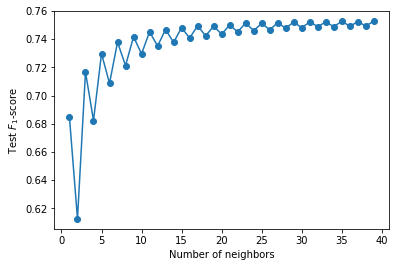

In [11]:
plt.plot(n_neigh,cvs,'-o');
plt.ylabel('Test $F_1$-score');
plt.xlabel('Number of neighbors');

In [12]:
opt_n = np.argmax(cvs)+1

In [13]:
from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.3, random_state=0)

knn_model = neighbors.KNeighborsClassifier(n_neighbors=opt_n, n_jobs=2, p=1)
knn_model.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=39, p=1,
           weights='uniform')

Small train_test split to estimate test f1-score:

In [14]:
Z_train = knn_model.predict(X_train)
Z_test = knn_model.predict(X_test)
print_eval(Y_train, Z_train, Y_test, Z_test)

Training set evaluation
              precision    recall  f1-score   support

           1       0.73      0.81      0.77     40183

   micro avg       0.73      0.81      0.77     40183
   macro avg       0.73      0.81      0.77     40183
weighted avg       0.73      0.81      0.77     40183

Testing set evaluation
              precision    recall  f1-score   support

           1       0.72      0.80      0.75     17293

   micro avg       0.72      0.80      0.75     17293
   macro avg       0.72      0.80      0.75     17293
weighted avg       0.72      0.80      0.75     17293



In [15]:
Z = knn_model.predict(X)

In [16]:
print(classification_report(Y, Z, labels =[1]))

              precision    recall  f1-score   support

           1       0.43      0.81      0.56     57476

   micro avg       0.43      0.81      0.56     57476
   macro avg       0.43      0.81      0.56     57476
weighted avg       0.43      0.81      0.56     57476



## 2. Submission code 

In [35]:
N_TEST_IMAGES = 50

test_data_filename = ['test_set_images/test_'+str(i)+'/test_'+str(i)+'.png' for i in range(1,N_TEST_IMAGES+1)]


In [52]:
knn_model = neighbors.KNeighborsClassifier(n_neighbors=opt_n, n_jobs=2, p=1)
knn_model.fit(X_resampled, Y_resampled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=2, n_neighbors=37, p=1,
           weights='uniform')

In [53]:
prediction_testing_dir = "predictions_testing_knn/"
if not os.path.isdir(prediction_testing_dir):
    os.mkdir(prediction_testing_dir)
for i in range(1, N_TEST_IMAGES+1):
    X_ = extract_img_features(test_data_filename[i - 1], '3d')
    Zi = knn_model.predict(X_)
    pimg=img_float_to_uint8(label_to_img(608, 608, patch_size, patch_size, Zi))
    Image.fromarray(pimg).save(prediction_testing_dir + "prediction_" + str(i) + ".png")

In [54]:
from mask_to_submission_knn import *

In [55]:
# if __name__ == '__main__':
#     submission_filename = 'prediction_KNN.csv'
#     image_filenames = []
#     for i in range(1, 51):
#         image_filename = 'predictions_testing_knn/prediction_' +  str(i) + '.png'
#         print(image_filename)
#         image_filenames.append(image_filename)
#     masks_to_submission(submission_filename, *image_filenames)


predictions_testing_knn/prediction_1.png
predictions_testing_knn/prediction_2.png
predictions_testing_knn/prediction_3.png
predictions_testing_knn/prediction_4.png
predictions_testing_knn/prediction_5.png
predictions_testing_knn/prediction_6.png
predictions_testing_knn/prediction_7.png
predictions_testing_knn/prediction_8.png
predictions_testing_knn/prediction_9.png
predictions_testing_knn/prediction_10.png
predictions_testing_knn/prediction_11.png
predictions_testing_knn/prediction_12.png
predictions_testing_knn/prediction_13.png
predictions_testing_knn/prediction_14.png
predictions_testing_knn/prediction_15.png
predictions_testing_knn/prediction_16.png
predictions_testing_knn/prediction_17.png
predictions_testing_knn/prediction_18.png
predictions_testing_knn/prediction_19.png
predictions_testing_knn/prediction_20.png
predictions_testing_knn/prediction_21.png
predictions_testing_knn/prediction_22.png
predictions_testing_knn/prediction_23.png
predictions_testing_knn/prediction_24.png
p